# Exploratory Data Analysis

This notebook presents an exploratory data analysis (EDA) on the **Spatial Dynamic Wind Power Forecasting (SDWPF)** dataset, released by **Longyuan Power Group Corp. Ltd** as part of a forecasting competition. Unlike traditional wind power forecasting (WPF) datasets that treat the problem purely as a time series task, this dataset provides **spatial** and **contextual** information, enabling the modeling of interactions among turbines and their environments.

## 1. Purpose of this Notebook

The goal of this notebook is to perform an in-depth exploratory analysis to:

- Understand the distribution and quality of each feature
- Identify outliers and missing data
- Analyze correlations between input variables and the target (`Patv`)
- Visualize spatial layout and temporal patterns
- Lay the foundation for feature engineering and predictive modeling

In [1]:
# S2R-WIND: Semi-supervised Regression for Wind Forecasting
# Author: Nicolas Pinto
# Date: 24 June 2025

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_theme(style='whitegrid', palette='muted', font_scale=1.2)

location_df = pd.read_csv("../data/raw/turb_location.csv")
wtb_df = pd.read_csv("../data/raw/wtbdata_245days.csv")

## 2. Dataset Overview

The dataset contains:
- **Dynamic time-series measurements** sampled every **10 minutes** from **134 wind turbines**
- **Contextual sensor data** from both environmental and internal turbine systems
- **Geographical coordinates** (X, Y) for each turbine in the wind farm

Each row in the main dataset represents a 10-minute record from a single turbine and includes the following variables:

| Column | Name    | Description |
|--------|---------|-------------|
| 1 | `TurbID` | Unique wind turbine ID |
| 2 | `Day` | Day index (from 1 to 245) |
| 3 | `Tmstamp` | Time within the day (format: `HH:MM`) |
| 4 | `Wspd` (m/s) | Wind speed measured by the anemometer |
| 5 | `Wdir` (°) | Relative wind direction (vs. nacelle) |
| 6 | `Etmp` (℃) | Ambient temperature |
| 7 | `Itmp` (℃) | Internal nacelle temperature |
| 8 | `Ndir` (°) | Nacelle yaw angle |
| 9–11 | `Pab1`, `Pab2`, `Pab3` (°) | Blade pitch angles for blades 1–3 |
| 12 | `Prtv` (kW) | Reactive power |
| 13 | `Patv` (kW) | Active power output (**target variable**) |

---

### `turb_location.csv`

This file gives us the spatial information of the turbines. It includes a unique identifier for each turbine, labeled as `TurbID`, along with two numerical values, `X` and `Y`, which represent their coordinates in space. The number of rows corresponds to the total number of turbines, while the three columns represent the ID and the two coordinate values.

As part of the initial check, it’s important to verify whether any of these coordinate fields are missing. Missing values could point to issues in data collection or export. Additionally, we want to look at the range of values in the coordinates to understand the geographic spread or potential anomalies.

In [2]:
print(location_df.head())
print("Shape:", location_df.shape)


   TurbID          x           y
0       1  3349.8515  5939.23193
1       2  3351.0017  6416.64673
2       3  3314.7797  6892.18395
3       4  3352.0940  7366.14203
4       5  3355.3420  7841.20175
Shape: (134, 3)


### `wtbdata_245days.csv`

This second file contains much more detailed data: it’s a time series of turbine measurements recorded at 10-minute intervals, across a period of 245 days. It has around 14 columns, with each row representing a new timestamped entry for a turbine.

Among the fields, you’ll find `Tmstamp` for the timestamp, and a variety of sensor readings. For instance, `Wspd` and `Wdir` tell us about the wind speed and direction. `Etmp` and `Itmp` provide the external and internal temperatures. Then there’s a group of columns related to the turbines’ internal mechanics and power output—things like `Ndir`, `Pab1`, `Pab2`, `Pab3`, `Prtv`, and `Patv`.

Before diving into deeper analysis, we need to perform some basic checks here too. First, we’ll look for missing values in each of the columns. We should also ensure the data types are consistent—especially making sure timestamps are correctly parsed as datetime objects. Finally, it’s helpful to confirm the total time span covered by the data to be sure it aligns with expectations.

In [3]:
print(wtb_df.head())
print("Shape:", wtb_df.shape)


   TurbID  Day Tmstamp  Wspd  Wdir   Etmp   Itmp   Ndir  Pab1  Pab2  Pab3  \
0       1    1   00:00   NaN   NaN    NaN    NaN    NaN   NaN   NaN   NaN   
1       1    1   00:10  6.17 -3.99  30.73  41.80  25.92   1.0   1.0   1.0   
2       1    1   00:20  6.27 -2.18  30.60  41.63  20.91   1.0   1.0   1.0   
3       1    1   00:30  6.42 -0.73  30.52  41.52  20.91   1.0   1.0   1.0   
4       1    1   00:40  6.25  0.89  30.49  41.38  20.91   1.0   1.0   1.0   

   Prtv    Patv  
0   NaN     NaN  
1 -0.25  494.66  
2 -0.24  509.76  
3 -0.26  542.53  
4 -0.23  509.36  
Shape: (4727520, 13)


## 3. Parse Timestamp to Full Datetime

In [4]:
# Convert 'Day' and 'Tmstamp' to a single datetime column

wtb_df['Tmstamp'] = wtb_df['Tmstamp'].astype(str) + ':00'

# Day 1 corresponds to a base date — let's assume "2021-01-01" for consistency
base_date = pd.Timestamp("2021-01-01")

# Create a new 'Timestamp' column by combining 'Day' and 'Tmstamp'
wtb_df['Timestamp'] = wtb_df.apply(
    lambda row: base_date + pd.Timedelta(days=int(row['Day']) - 1) + pd.to_timedelta(row['Tmstamp']), axis=1
)

wtb_df.drop(columns=['Day', 'Tmstamp'], inplace=True)

# Set datetime index (optional but useful)
wtb_df['Timestamp'] = pd.to_datetime(wtb_df['Timestamp'])


In [5]:
print(wtb_df.head())

   TurbID  Wspd  Wdir   Etmp   Itmp   Ndir  Pab1  Pab2  Pab3  Prtv    Patv  \
0       1   NaN   NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN     NaN   
1       1  6.17 -3.99  30.73  41.80  25.92   1.0   1.0   1.0 -0.25  494.66   
2       1  6.27 -2.18  30.60  41.63  20.91   1.0   1.0   1.0 -0.24  509.76   
3       1  6.42 -0.73  30.52  41.52  20.91   1.0   1.0   1.0 -0.26  542.53   
4       1  6.25  0.89  30.49  41.38  20.91   1.0   1.0   1.0 -0.23  509.36   

            Timestamp  
0 2021-01-01 00:00:00  
1 2021-01-01 00:10:00  
2 2021-01-01 00:20:00  
3 2021-01-01 00:30:00  
4 2021-01-01 00:40:00  


## 4. Missing Values Check

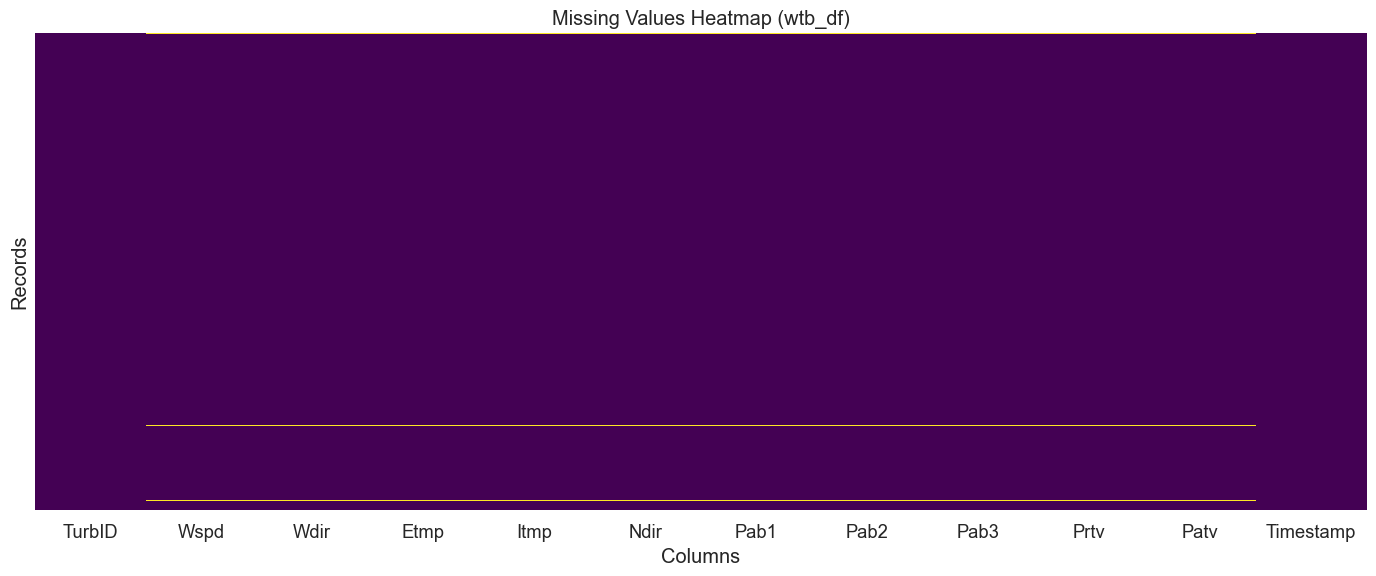


Missing Data Summary:


,Missing Values,Percentage (%)
Wspd,49518,1.05
Wdir,49518,1.05
Etmp,49518,1.05
Itmp,49518,1.05
Pab3,49518,1.05
Ndir,49518,1.05
Pab1,49518,1.05
Pab2,49518,1.05
Patv,49518,1.05
Prtv,49518,1.05


In [6]:
# Heatmap of missing values
plt.figure(figsize=(14, 6))
sns.heatmap(wtb_df.isnull(), cbar=False, cmap="viridis", yticklabels=False)
plt.title("Missing Values Heatmap (wtb_df)")
plt.xlabel("Columns")
plt.ylabel("Records")
plt.tight_layout()
plt.show()

missing_values = wtb_df.isnull().sum()
missing_percentage = (missing_values / len(wtb_df)) * 100

missing_summary = pd.DataFrame({
    "Missing Values": missing_values,
    "Percentage (%)": missing_percentage.round(2)
}).sort_values(by="Percentage (%)", ascending=False)

print("\nMissing Data Summary:")
display(missing_summary[missing_summary["Missing Values"] > 0])


### Missing Data Analysis

The heatmap above provides a visual overview of missing values across all columns in the `wtb_df` dataset. Each row represents a time record, and each column corresponds to a feature.

From the plot, we observe that:

- A **small number of rows** contain missing values, indicated by the few bright horizontal lines in the heatmap.
- These missing values appear to affect **multiple columns simultaneously**, which may suggest issues with data transmission or logging for specific time intervals.

Given the relatively low frequency of missing entries it is reasonable to **remove rows with missing data** entirely, especially since their presence is sparse and the analysis is time series-based.


In [7]:
print("Original dataset shape:", wtb_df.shape)

wtb_df_clean = wtb_df.dropna()

print("Cleaned dataset shape:", wtb_df_clean.shape)

# Number of rows removed
rows_dropped = len(wtb_df) - len(wtb_df_clean)
print(f"Rows with missing values removed: {rows_dropped} ({(rows_dropped / len(wtb_df)) * 100:.2f}%)")

Original dataset shape: (4727520, 12)
Cleaned dataset shape: (4678002, 12)
Rows with missing values removed: 49518 (1.05%)


## 5. Univariate Analysis and Range Standardization

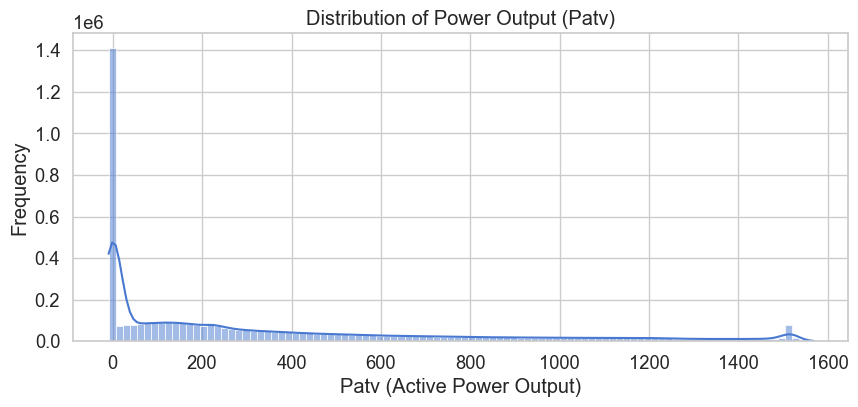

In [8]:
# Distribution of the target variable (Patv)
plt.figure(figsize=(10, 4))
sns.histplot(wtb_df_clean['Patv'], bins=100, kde=True)
plt.title('Distribution of Power Output (Patv)')
plt.xlabel('Patv (Active Power Output)')
plt.ylabel('Frequency')
plt.show()


The histogram above shows the distribution of active power output (`Patv`) across all turbines.

We can observe a significant peak at 0 kW, indicating that a large portion of the data corresponds to periods when turbines were not generating any power. This could be due to low wind speeds, maintenance periods, or other operational shutdowns.

The distribution is heavily right-skewed, with a long tail extending up to around 1500 kW, which likely represents the rated power limit of the turbines. There's also a small but noticeable peak near this maximum value, suggesting that turbines often operate at full capacity when wind conditions are optimal.

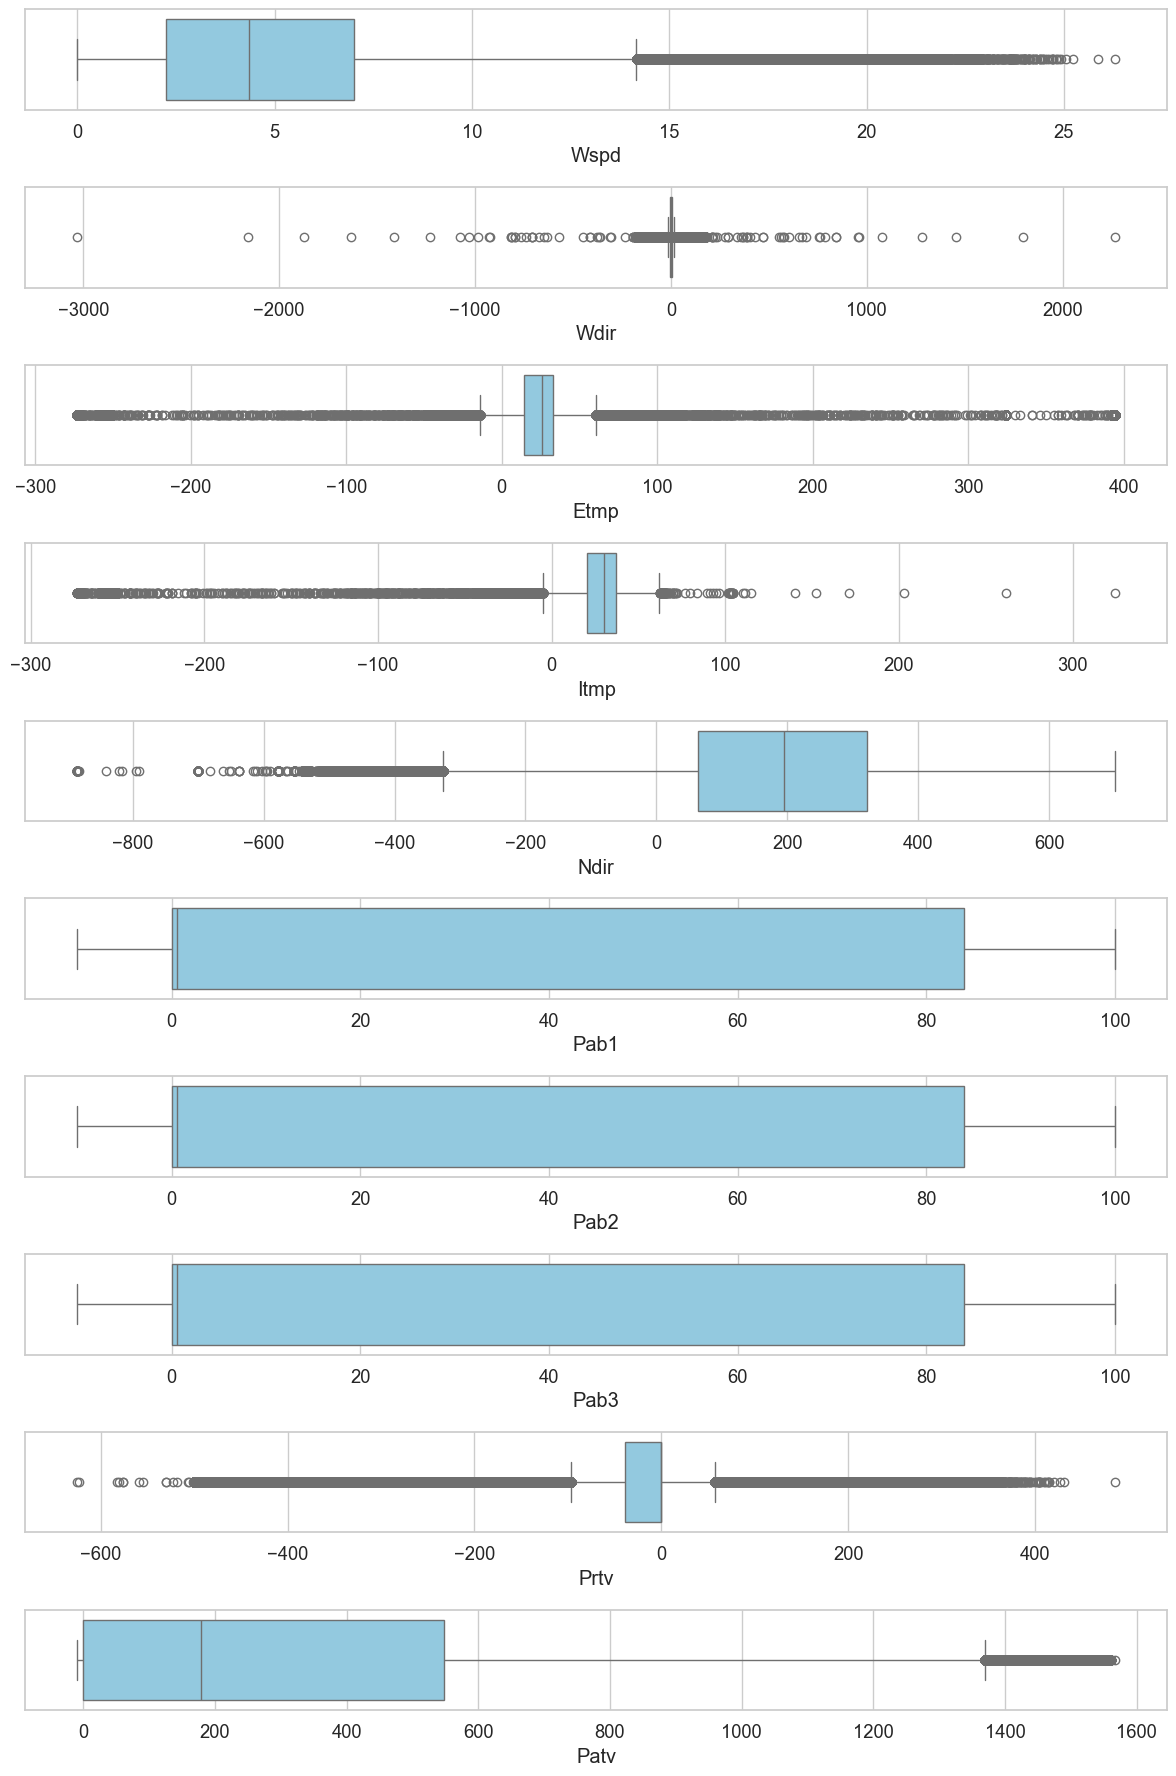

In [9]:
features_to_check = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir',
                     'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']

plt.figure(figsize=(12, len(features_to_check) * 1.8))

for i, col in enumerate(features_to_check, 1):
    plt.subplot(len(features_to_check), 1, i)
    sns.boxplot(x=wtb_df_clean[col], color='skyblue')
    plt.xlabel(col)
    plt.tight_layout()

plt.show()


**Boxplot Analysis of Features**

The figure above displays boxplots for several features. From the distributions shown in the boxplots, we can make the following observations:

- **Wspd (Wind Speed):** The `Wspd` boxplot shows a slightly right-skewed distribution, indicating more observations at lower wind speeds and fewer at higher speeds. There are numerous high-value outliers, which are typical in wind turbine data where high wind speeds and power outputs are less frequent. Most data is concentrated between approximately 0 and 8 m/s, with a median around 4 m/s.

- **Wdir (Wind Direction):** `Wdir` presents a very dispersed distribution with a wide range of values and numerous positive and negative outliers. Most data clusters around 0, but the presence of outliers suggests possible anomalous readings or a very broad measurement range.

- **Etmp (External Temperature) and Itmp (Internal Temperature):** Both temperature variables (`Etmp` and `Itmp`) contain many extreme values and significant outliers. Specifically, `Etmp` shows a large number of both positive and negative outliers, with most data seemingly concentrating around 0 but with considerable spread. `Itmp` exhibits a similar distribution, with a wide range of outliers. These could be the result of sensor issues or invalid readings and may require further cleaning or capping of values.

- **Ndir (Nacelle Direction):** `Ndir` shows a more concentrated distribution compared to `Wdir`, with most data between approximately 150 and 350. However, outliers are still present, though fewer in number and distributed over a narrower range than wind direction.

- **Pab1 (°), Pab2 (°), Pab3 (°)** - Pitch angle of blade 1, 2, and 3 display very similar distributions, concentrated in a narrow range (approximately 0-100 degrees) with few outliers. The pitch angle of the blades is crucial for controlling the aerodynamic efficiency and thus the power output of the turbine. The similarity suggests synchronized control of the blades. The narrow range implies that for much of the time, the blades are either feathered (pitched to minimize wind capture, e.g., when the turbine is idle or in high winds) or pitched to an optimal angle for power generation. Outliers might represent extreme pitching for safety or operational adjustments.

- **Prtv (Reactive Voltage):** `Prtv` shows a broadly dispersed distribution with numerous positive and negative outliers, similar to `Etmp` and `Itmp`. Most data clusters around 0, but the wide range of outliers suggests the need for careful analysis and cleaning.

- **Patv (Total Active Power):** `Patv` exhibits a right-skewed distribution, with a large concentration of values close to 0. This is consistent with earlier analysis and suggests frequent periods of turbine inactivity or low wind conditions that do not generate power. Higher-value outliers are also present, representing times of greater energy production. The distribution of `Patv` aligns with expectations for wind turbine power data.

Overall, the presence of significant outliers in almost all variables (particularly `Wdir`, `Etmp`, `Itmp`, `Prtv`) suggests that careful data preprocessing (e.g., outlier removal, transformation, or imputation) may be necessary before applying machine learning models. Skewed distributions (as in `Wspd` and `Patv`) might also benefit from transformations to improve the performance of certain algorithms.

In [10]:
print("Previous dataset shape:", wtb_df_clean.shape)
initial_shape = wtb_df_clean.shape[0]

# Definition of plausible value ranges for each column
plausible_ranges = {
    'Wspd': (0, 30),       # Wind speed in m/s (0-30 m/s is a common range for wind turbines)
    'Wdir': (-360, 360),   # Wind direction in degrees (0-360)
    'Etmp': (-40, 60),     # External temperature
    'Itmp': (-20, 120),    # Internal temperature
    'Ndir': (-360, 360),   # Nacelle direction in degrees (0-360)
    'Pab1': (-10, 100),    # Typically 0–25° during operation; 90° in shutdown/safety mode.
    'Pab2': (-10, 100),
    'Pab3': (-10, 100),
    'Prtv': (-1600, 1600), # Reactive power (kW)
    'Patv': (0, 1600)      # Active power (kW)
}

for col, (min_val, max_val) in plausible_ranges.items():
    before_rows = wtb_df_clean.shape[0]
    wtb_df_clean = wtb_df_clean[wtb_df_clean[col].between(min_val, max_val)]
    after_rows = wtb_df_clean.shape[0]
    removed = before_rows - after_rows
    print(f"{col}: removed {removed} rows ({(removed / before_rows * 100):.2f}%)")

print("Actual dataset shape:", wtb_df_clean.shape)

# Total number of rows removed
total_removed = initial_shape - wtb_df_clean.shape[0]
print(f"\nTotal rows with unrealistic values removed: {total_removed} ({(total_removed / initial_shape) * 100:.2f}%)")

Previous dataset shape: (4678002, 12)
Wspd: removed 0 rows (0.00%)
Wdir: removed 60 rows (0.00%)
Etmp: removed 277071 rows (5.92%)
Itmp: removed 676 rows (0.02%)
Ndir: removed 683119 rows (15.52%)
Pab1: removed 0 rows (0.00%)
Pab2: removed 0 rows (0.00%)
Pab3: removed 0 rows (0.00%)
Prtv: removed 0 rows (0.00%)
Patv: removed 1010495 rows (27.19%)
Actual dataset shape: (2706581, 12)

Total rows with unrealistic values removed: 1971421 (42.14%)


## 6. Temporal Trends

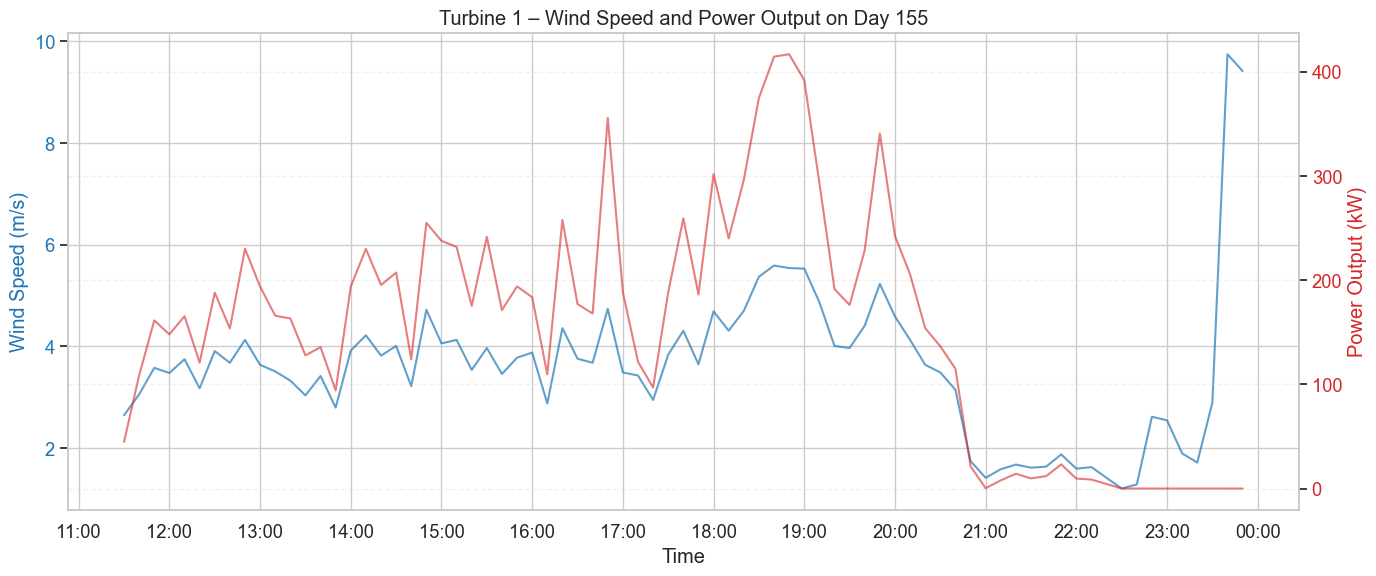

In [11]:
import matplotlib.dates as mdates

# Select a sample turbine and one day (e.g., day 155)
sample_turbine = wtb_df_clean['TurbID'].unique()[0]
sample_day = 155

# Extract the date corresponding to the given day of the year 155
start_date = wtb_df_clean['Timestamp'].dt.normalize().min() + pd.Timedelta(days=sample_day - 1)
end_date = start_date + pd.Timedelta(days=1)

filtered_df = wtb_df_clean[
    (wtb_df_clean['TurbID'] == sample_turbine) &
    (wtb_df_clean['Timestamp'] >= start_date) &
    (wtb_df_clean['Timestamp'] < end_date)
]

fig, ax1 = plt.subplots(figsize=(14, 6))

# Wind speed
color1 = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Wind Speed (m/s)', color=color1)
ax1.plot(filtered_df['Timestamp'], filtered_df['Wspd'], color=color1, label='Wind Speed', alpha=0.7, linewidth=1.5)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))

# Power output
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Power Output (kW)', color=color2)
ax2.plot(filtered_df['Timestamp'], filtered_df['Patv'], color=color2, label='Power Output', alpha=0.6, linewidth=1.5)
ax2.tick_params(axis='y', labelcolor=color2)

plt.title(f"Turbine {sample_turbine} – Wind Speed and Power Output on Day {sample_day}")
fig.tight_layout()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


The plot above shows the wind speed (in blue) and power output (in red) for Turbine 1 over the course of Day 155, from 11:00 AM until midnight.

We observe the following trends:

- **11:00 - 14:00:** During these hours, wind speeds were relatively low, fluctuating mostly between 2 m/s and 4 m/s. Correspondingly, the power output remained low, generally below 200 kW, though consistently producing some power.
- **14:00 - 20:00:** From mid-afternoon into the evening, wind speeds became more dynamic. We see several periods of increased wind speed, particularly around 17:00 (peaking near 4.5 m/s) and 19:00 (peaking around 5.5 m/s). The power output closely followed these fluctuations, rising sharply in response. The highest power output during this period reached nearly 450 kW around 19:00, coinciding with a notable surge in wind speed.
- **20:00 - 21:00:** After 20:00, both wind speed and power output generally declined, with wind speed dropping to around 1 m/s and power output reducing to very low levels, near 0 kW.
- **21:00 - 00:00:** The turbine entered a period of very low or zero power generation. Interestingly, a significant spike in wind speed occurs just before midnight, reaching almost 10 m/s. However, despite this strong wind, the power output at this specific moment remains at 0 kW. This suggests the turbine might have been curtailed, shut down due to excessively high winds, or in a non-operational state.

This plot generally illustrates the strong positive correlation between wind speed and active power production: higher wind speeds typically lead to increased power output. However, the event near midnight, where high wind speed does not result in power generation, highlights that other factors (such as turbine cut-out speeds, maintenance, or grid curtailment) can also influence the actual power output, even under favorable wind conditions.

## 7. Spatial Visualization


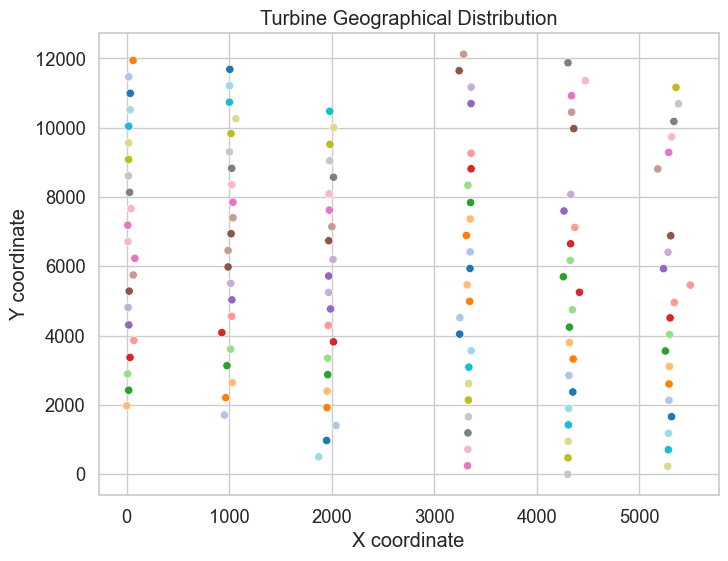

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=location_df, x='x', y='y', hue='TurbID', palette='tab20', legend=False)
plt.title('Turbine Geographical Distribution')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.grid(True)
plt.show()


## 8. Correlation Analysis

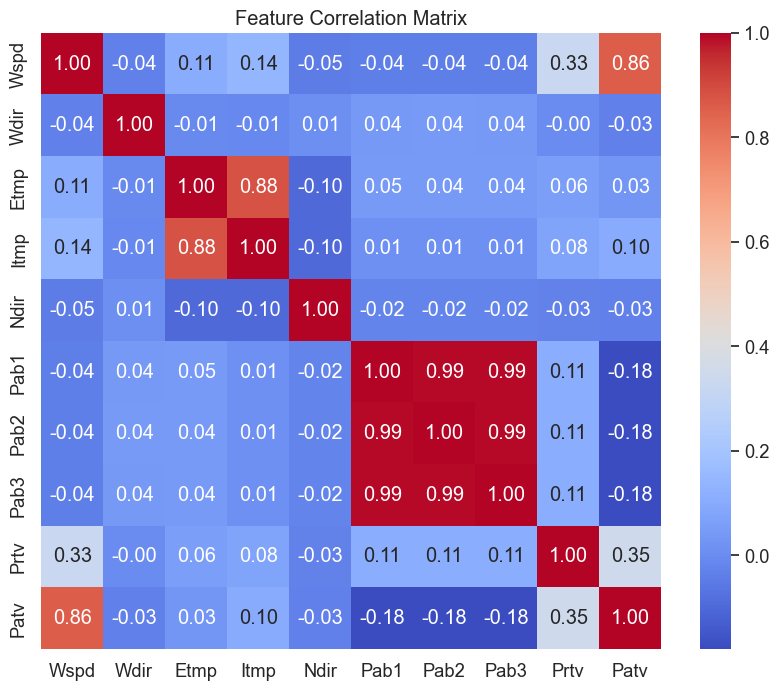

In [13]:
numeric_df = wtb_df_clean.select_dtypes(include=['float64', 'int64']).drop(columns=['TurbID'])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


**Correlation Analysis Observations**

From the correlation heatmap:

- Wind Speed (`Wspd`) has a strong positive correlation (0.81) with the power output (`Patv`), confirming it as a key predictive feature.
- `Pab1`, `Pab2`, and `Pab3` are perfectly correlated with each other and negatively correlated with `Patv` (−0.51). These likely reflect internal power absorption or brake activity.
- Features like `Wdir`, `Etmp`, and `Ndir` show very low correlation with `Patv`, suggesting a limited or non-linear effect.
- `Day` and `TurbID` have no predictive power on their own and may serve only for indexing/grouping.

As a result:
1. `Wspd` should be prioritized as the main input feature.  
2. Only one of `Pab1`, `Pab2`, or `Pab3` should be retained to reduce multicollinearity.  
3. Features with low correlation may still be valuable in non-linear models (e.g., random forests or neural networks).


In [14]:
wtb_df_clean = wtb_df_clean.drop(columns=['Pab2', 'Pab3'])

## 9. Outlier Detection & Discussion

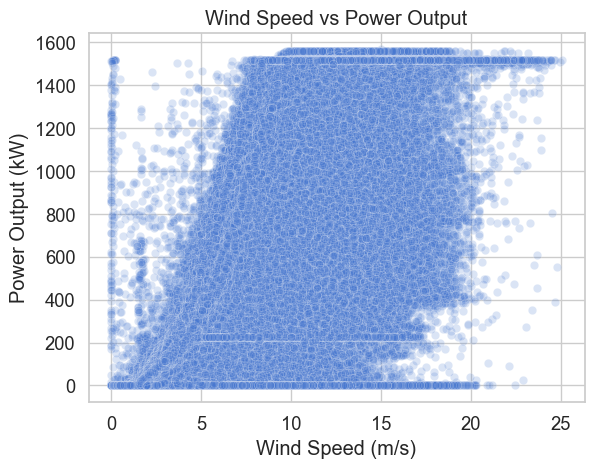

In [15]:
sns.scatterplot(data=wtb_df_clean, x='Wspd', y='Patv', alpha=0.2)
plt.title("Wind Speed vs Power Output")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power Output (kW)")
plt.show()


The scatter plot above displays the relationship between wind speed and power output across the entire dataset. Several key patterns emerge:

- **Cut-in Region (0–3 m/s):** Power output remains near zero at low wind speeds, indicating the turbine does not operate below the cut-in speed threshold.
- **Linear Increase (3–12 m/s):** As wind speed increases, power output rises sharply in a near-linear fashion. This is the turbine's optimal operational range.
- **Rated Plateau (\~12–15 m/s):** The turbine reaches its rated power (around 1500 kW), and output remains constant despite increasing wind speed.
- **Cut-out and Noise (above \~20 m/s):** A decline and scatter of power output occurs at very high wind speeds, suggesting the turbine may shut down to prevent damage, or readings are affected by noise/outliers.

This characteristic S-curve distribution reflects typical wind turbine performance behavior and confirms that the turbine is generally operating as expected within its designed efficiency envelope.

Special attention should be given to certain patterns in the dataset that may indicate sensor faults or operational anomalies:

- **`Wspd ≈ 0` but `Patv > 0`**
  This is physically implausible, as power generation requires wind. Such records may indicate sensor faults, data logging errors, or incorrect readings.

- **`Wspd > 0` but `Patv = 0`**
  These cases may be valid if the wind speed is **below the turbine's cut-in threshold**, meaning the turbine is not yet active. However, frequent occurrences, especially at moderate wind speeds, could suggest downtime, curtailment, or turbine malfunction.


In [16]:
print("Previous dataset shape:", wtb_df_clean.shape)
prev_rows = wtb_df_clean.shape[0]

cut_in_threshold = 3.0           # Minimum wind speed required to start producing power
low_wind_threshold = 1.5         # Very low wind speed
high_power_threshold = 200       # Power value considered too high for low wind

# Condition 1: Zero wind speed but positive power output (physically implausible)
invalid_power = (wtb_df_clean['Wspd'] == 0) & (wtb_df_clean['Patv'] > 0)

# Condition 2: Wind speed above cut-in threshold but zero power output (turbine should be generating)
no_output_above_cutin = (wtb_df_clean['Wspd'] > cut_in_threshold) & (wtb_df_clean['Patv'] == 0)

# Condition 3: Very low wind speed but unusually high power output (suspicious)
high_power_low_wind = (wtb_df_clean['Wspd'] < low_wind_threshold) & (wtb_df_clean['Patv'] > high_power_threshold)

# Remove all rows that match any of the above anomalies
wtb_df_clean = wtb_df_clean[~(invalid_power | no_output_above_cutin | high_power_low_wind)].copy()

print("Cleaned dataset shape:", wtb_df_clean.shape)

# Report number of rows removed
rows_dropped = prev_rows - wtb_df_clean.shape[0]
print(f"Rows with anomalous wind/power values removed: {rows_dropped} ({(rows_dropped / prev_rows) * 100:.2f}%)")


Previous dataset shape: (2706581, 10)
Cleaned dataset shape: (2683752, 10)
Rows with anomalous wind/power values removed: 22829 (0.84%)


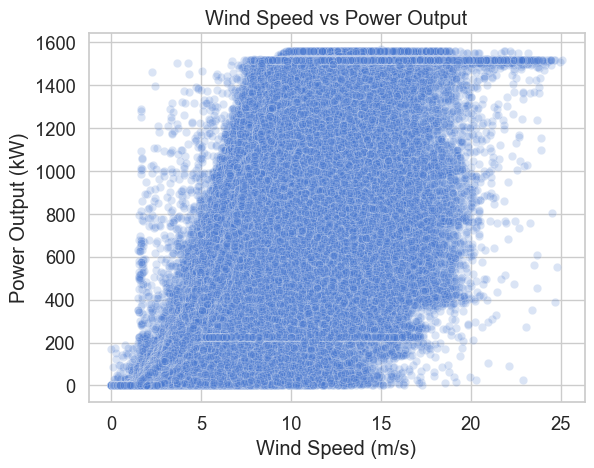

In [17]:
sns.scatterplot(data=wtb_df_clean, x='Wspd', y='Patv', alpha=0.2)
plt.title("Wind Speed vs Power Output")
plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Power Output (kW)")
plt.show()

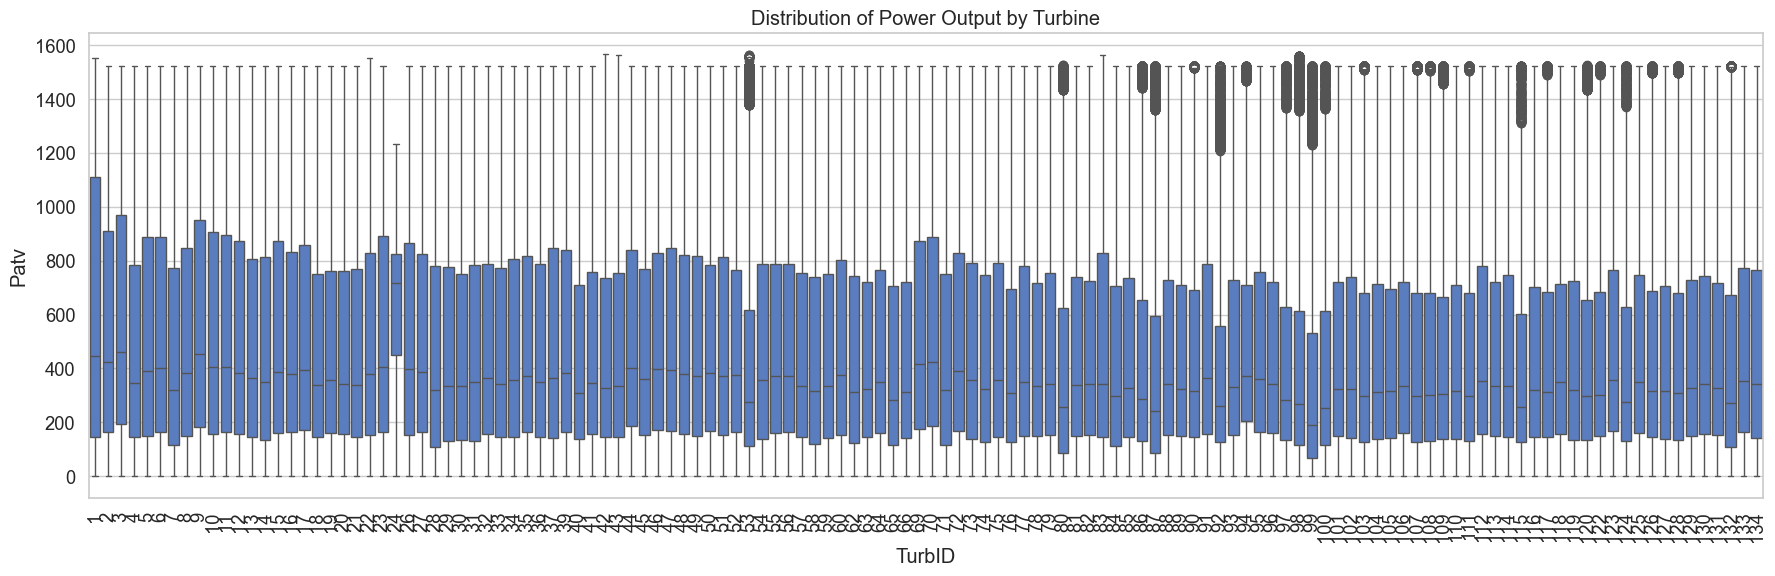

In [18]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=wtb_df_clean, x='TurbID', y='Patv')
plt.title("Distribution of Power Output by Turbine")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


The boxplot visualizes the distribution of active power output (`Patv`) for each wind turbine (`TurbID`).

- **General Consistency:** Most turbines show a similar median power output (around 200-400 kW) and interquartile range, suggesting consistent operational characteristics across the fleet.
- **High-Value Outliers:** Nearly all turbines exhibit numerous high-value outliers, representing periods of peak power generation during strong winds.
- **Potential Anomalies/High Performers:** A cluster of turbines, particularly from TurbID ~90-100, displays a higher density of extreme outliers (up to 1600 kW). This could indicate either exceptional performance, specific site conditions with higher winds, or warrant further investigation for potential data anomalies.
- **Frequent Low Output:** The lower quartiles and whiskers frequently extend to or near 0 kW, indicating that turbines often operate at very low or no power output due to insufficient wind, curtailment, or downtime.

In [19]:
cols = wtb_df_clean.columns.tolist()
cols.remove('Timestamp')
cols.insert(1, 'Timestamp')
wtb_df_clean = wtb_df_clean[cols]


In [20]:
wtb_df_clean.to_csv("../data/interim/wtbdata_clean.csv", index=False)